In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, MinMaxScaler
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import imblearn
from sklearn import metrics

from utils.general_utils import get_outlier_info, get_outlier_val_counts
from utils.saver_utils import save_normalizer, load_normalizer
from utils.saver_utils import save_dataset, load_dataset 

In [2]:
from sklearn.ensemble import RandomForestClassifier
from utils.general_utils import save_model
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest

import imblearn
from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA

In [6]:
# datasetv2_save_path = "dataset/dataset_v2"
# trainX, trainY, testX, testY = load_dataset(path=datasetv2_save_path)
# scalerTrainX = load_normalizer(path=datasetv2_save_path, task='classification')

In [3]:
def knn_impute(df, missing_val_indicator=999, int_col_index:list=[]):
    
    missing_vals = np.sum(df == missing_val_indicator)
    missing_cols_valuecounts = missing_vals[missing_vals > 0]
    impute_knn = KNNImputer(n_neighbors=3, missing_values=999)
    imputed_arr = impute_knn.fit_transform(df.drop(columns=['ID']))
    
    for idx in int_col_index:
        imputed_arr[:, idx] = np.rint(imputed_arr[:, idx])

    imputed_df = pd.DataFrame.from_records(imputed_arr, columns=df.columns[1:])
    
    return imputed_df

def get_cat_to_one_hot(df, multi_cat_cols):
    df = pd.get_dummies(df, columns=multi_cat_cols)
    
    multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']
    
    for column in multi_category_variables:
        df[column] = df[column].astype(np.float32)
        
    return df
    

In [4]:
og_df = pd.read_csv('dataset/TrainDataset2023.csv')
og_df.rename(columns={'pCR (outcome)': 'pcr', 'RelapseFreeSurvival (outcome)': 'rfs'}, inplace=True)


int_col_mask = og_df.drop(columns=['ID']).dtypes == 'int64'
categorical_features = list(og_df.drop(columns=['ID']).columns[int_col_mask])

#Ignoring 'original_shape_VoxelVolume' because even though it is a int column it is not a categorical feature
categorical_features.remove('original_shape_VoxelVolume')

In [7]:

int_col_index = [i for i, x in enumerate(np.array(int_col_mask)) if x]

imputed_df = knn_impute(og_df, int_col_index = int_col_index)
multiclass_categorical_features = []
others = []

for cat_col_name in categorical_features:
    temp_len = len(imputed_df[cat_col_name].value_counts())
    if temp_len > 2:
        multiclass_categorical_features.append(cat_col_name)
    else:
        others.append(temp_len)

multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = categorical_features + multi_category_variables
temp_categorical_features_labels = categorical_features_labels

# Removing multiclass_categorical_features because these features are 
# converted to one-hot encoding

for col_name in multiclass_categorical_features:
    temp_categorical_features_labels.remove(col_name)

temp_categorical_features_labels.remove('pcr')



In [8]:

imputed_df = get_cat_to_one_hot(imputed_df, multi_cat_cols=multiclass_categorical_features)
imputed_df.head()


nan_cols = imputed_df.columns[imputed_df.isnull().sum() > 0]

print(f'NaN Columns : {nan_cols}')
if len(nan_cols) > 0:
    imputed_df.drop(columns=nan_cols, inplace=True)


NaN Columns : Index([], dtype='object')


In [9]:


target = 'pcr'

# Ignoring RFS too, because we decided to keep RFS as RFS and PCR are related and often used clinically for analysis
correlation_matrix = imputed_df.drop(columns=['rfs', 'pcr']).corr()


# Level 1 Correlation, comparing all the features as a pair exhaustively
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            colname = correlation_matrix.columns[i]
            high_corr_pairs.append((correlation_matrix.columns[j], colname))


# Level 2 correlation, from the pair of highly correlated features remove only those which are less correlated with target variable
features_to_remove = set()
for pair in high_corr_pairs:
    if abs(imputed_df[pair[0]].corr(imputed_df[target])) > abs(imputed_df[pair[1]].corr(imputed_df[target])):
        features_to_remove.add(pair[1])
    else:
        features_to_remove.add(pair[0])

# Dropping the selected features
imputed_df_reduced = imputed_df.drop(columns=features_to_remove)


In [10]:
train, test = train_test_split(imputed_df_reduced, test_size=0.20)


In [11]:

categorical_cols = []
for col in imputed_df_reduced.drop(columns=['pcr', 'rfs']):
    temp_count = len(imputed_df_reduced[col].value_counts().index)
    if temp_count < 3:
        categorical_cols.append(col)

        


# Processing Continous and Categorical variable separately

In [13]:
trainX_df = train.drop(columns=['pcr'])
trainY_df = train['pcr']

testX_df = test.drop(columns=['pcr'])
testY_df = test['pcr']

#'ChemoGrade_2.0'
multi_category_variables = ['ChemoGrade_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = ['ER', 'PgR', 'LNStatus', 'HER2', 'HistologyType', 'TrippleNegative'] + multi_category_variables

continous_features_labels = imputed_df_reduced.drop(columns=categorical_features_labels + ['pcr']).columns


In [14]:
trainX_continous_feature_array = trainX_df[continous_features_labels].to_numpy()
testX_continous_feature_array = testX_df[continous_features_labels].to_numpy()


scalerTrainX = MinMaxScaler()
scalerTrainY = MinMaxScaler()


trainX_cont_X = scalerTrainX.fit_transform(trainX_continous_feature_array)
testX_cont_X = scalerTrainX.transform(testX_continous_feature_array)

trainX_cat_X = train[categorical_features_labels].to_numpy()
testX_cat_X = test[categorical_features_labels].to_numpy()


trainX = np.hstack((trainX_cat_X, trainX_cont_X))   
testX = np.hstack((testX_cat_X, testX_cont_X))              

trainY = scalerTrainY.fit_transform(train['pcr'].to_numpy().reshape(-1, 1))
# pcrtrainY = train['pcr'].to_numpy().reshape(-1, 1)

testY = scalerTrainY.transform(test['pcr'].to_numpy().reshape(-1, 1))
# pcrtestY = test['pcr'].to_numpy().reshape(-1, 1)

In [15]:
trainX.shape, testX.shape, trainY.shape, testY.shape

((320, 44), (80, 44), (320, 1), (80, 1))

## Training with Isolation Forest

In [16]:
train_negative_pcr_data = trainX[(trainY == 0).ravel()]
train_positive_pcr_data = trainX[(trainY == 1).ravel()]

test_negative_pcr_data = testX[(testY == 0).ravel()]
test_positive_pcr_data = testX[(testY == 1).ravel()]

In [17]:
print(f'True contamination % : {len(train_positive_pcr_data)/(len(train_negative_pcr_data) + len(train_positive_pcr_data))}')

True contamination % : 0.2125


# Training the Isolation Forest on the majority class with Contamination as 0.05


In [18]:
isolation_anomaly_det = IsolationForest(contamination=0.05)  
isolation_anomaly_det.fit(train_negative_pcr_data)

IsolationForest(contamination=0.05)

In [19]:
test_neg_preds = isolation_anomaly_det.predict(test_negative_pcr_data)

In [20]:
# Evaluate the model's performance
print("Test Normal data:")
print(classification_report([0] * len(test_negative_pcr_data), (test_neg_preds == -1).astype(int),
                           zero_division = 0))

Test Normal data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        64
           1       0.00      0.00      0.00         0

    accuracy                           0.98        64
   macro avg       0.50      0.49      0.50        64
weighted avg       1.00      0.98      0.99        64



In [21]:
# Evaluate the model's performance
print("Test Normal data:")
print(classification_report([0] * len(test_negative_pcr_data), (test_neg_preds == -1).astype(int),
                           zero_division = 0))

Test Normal data:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        64
           1       0.00      0.00      0.00         0

    accuracy                           0.98        64
   macro avg       0.50      0.49      0.50        64
weighted avg       1.00      0.98      0.99        64



In [22]:
test_pos_preds = isolation_anomaly_det.predict(test_positive_pcr_data)

In [23]:
# Evaluate the model's performance
print("Test Anomaly data")
print(classification_report([1] * len(test_positive_pcr_data), (test_pos_preds == 1).astype(int),
                            zero_division = 0))

Test Anomaly data
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.88      0.93        16

    accuracy                           0.88        16
   macro avg       0.50      0.44      0.47        16
weighted avg       1.00      0.88      0.93        16



In [24]:
train_pos_preds = isolation_anomaly_det.predict(train_positive_pcr_data)

In [25]:
# Evaluate the model's performance
print("Train Anamoly Set:")
print(classification_report([1] * len(train_positive_pcr_data), (train_pos_preds == 1).astype(int),
                           zero_division = 0))

Train Anamoly Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.94      0.97        68

    accuracy                           0.94        68
   macro avg       0.50      0.47      0.48        68
weighted avg       1.00      0.94      0.97        68



# Final Report on testing Isolation Forest

In [26]:
test_preds = np.concatenate(((test_neg_preds == -1).astype(int),(test_pos_preds == 1).astype(int)))
true_labels_concat = np.concatenate((([0] * len(test_negative_pcr_data)), ([1] * len(test_positive_pcr_data))))

Balanced classification accuracy : 0.9296875

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        64
           1       0.93      0.88      0.90        16

    accuracy                           0.96        80
   macro avg       0.95      0.93      0.94        80
weighted avg       0.96      0.96      0.96        80



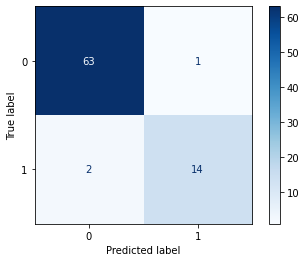

In [27]:
test_bas_error = balanced_accuracy_score(true_labels_concat, test_preds)
print(f'Balanced classification accuracy : {test_bas_error}')

print()

print(classification_report(true_labels_concat, test_preds))

confusion_matrix = metrics.confusion_matrix(true_labels_concat, test_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

# Testing Isolation FOrest with various Parameters

In [28]:
# Training the Isolation Forest on the majority class
isolation_anomaly_det = IsolationForest()  
isolation_anomaly_det.fit(train_negative_pcr_data)

IsolationForest()

In [29]:
test_pos_preds = isolation_anomaly_det.predict(test_positive_pcr_data)
test_neg_preds = isolation_anomaly_det.predict(test_negative_pcr_data)

In [30]:
test_preds = np.concatenate(((test_neg_preds == -1).astype(int),(test_pos_preds == 1).astype(int)))
true_labels_concat = np.concatenate((([0] * len(test_negative_pcr_data)), ([1] * len(test_positive_pcr_data))))

Balanced classification accuracy : 0.84375

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        64
           1       0.75      0.75      0.75        16

    accuracy                           0.90        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.90      0.90      0.90        80



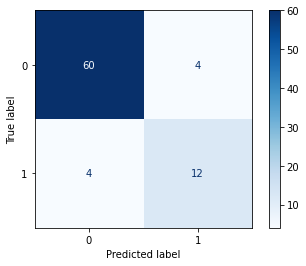

In [31]:
test_bas_error = balanced_accuracy_score(true_labels_concat, test_preds)
print(f'Balanced classification accuracy : {test_bas_error}')

print()

print(classification_report(true_labels_concat, test_preds))

confusion_matrix = metrics.confusion_matrix(true_labels_concat, test_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix,
                                            display_labels = [0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()

In [32]:
isolation_parameter_grid = np.linspace(0.05, 0.25, num=20)

In [33]:
metrics_dict = {}
for param in isolation_parameter_grid:
    isolation_anomaly_det = IsolationForest(contamination=param)  
    isolation_anomaly_det.fit(train_negative_pcr_data)
    
    test_pos_preds = isolation_anomaly_det.predict(test_positive_pcr_data)
    test_neg_preds = isolation_anomaly_det.predict(test_negative_pcr_data)
    
    test_preds = np.concatenate(((test_neg_preds == -1).astype(int),(test_pos_preds == 1).astype(int)))
    true_labels_concat = np.concatenate((([0] * len(test_negative_pcr_data)), ([1] * len(test_positive_pcr_data))))
    
    metrics_dict[param] = balanced_accuracy_score(true_labels_concat, test_preds)
    

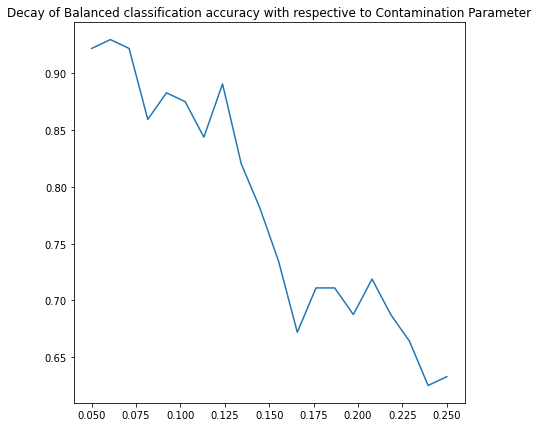

In [34]:
plt.figure(figsize = (7,7))
plt.plot(metrics_dict.keys(), metrics_dict.values())
plt.title('Decay of Balanced classification accuracy with respective to Contamination Parameter')
plt.show()

# TODO
1. Identify what happens if we decrease contamination more than we expect in the dataset